In [3]:
import pandas as pd
import matplotlib as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


# Fonctions

## Fonction d'évaluation du score de la prédiction

In [4]:
def rmsle(prediction, actual):
    assert len(prediction) == len(actual)
    return np.sqrt(np.mean(np.power(np.log1p(prediction)-np.log1p(actual),2)))

### Faire de cette fonction un scorer utilisable dans sklearn

In [5]:
from sklearn.metrics import make_scorer
rmsle_scorer = make_scorer(rmsle)

## Fonction d'évaluation de modèle

Cette fonction 
* evalue l'algorithme passé en paramêtre sur les X,y passés
* fit l'algorithme
* crée optionnellement un graphique avec les influences de chaque feature de X

In [6]:
def evaluate_model(evaluator, X, y, doPlot = True):
    from sklearn.cross_validation import cross_val_score
    print 'Evaluator is: ' + str(evaluator)
    print 'Mean score on 20 iterations is: '+str(mean(cross_val_score(evaluator, X, y, rmsle_scorer, cv = 20)))
    evaluator.fit(X,y)
    if hasattr(evaluator, 'coef_'):
        if doPlot :
            pd.DataFrame(evaluator.coef_, index=X.columns).plot(kind="bar")
        else :
            weight = pd.DataFrame(X.columns, evaluator.coef_)
            print weight.sort_index()
            #print X.columns + evaluator.coef_
            #print weight.columns
            #print X.columns.names
            #print evaluator.coef_

## Génération du fichier de Soumission
Cette fonction génére le fichier au format attendu en enlevant les valeurs négatives.

Les paramêtres attendus sont
1. un dataframe comportant une colonne 'id' avec les identifiants des observations
2. un dataframe comportant les prédictions correspondant aux observations (donc classés dans le même ordre) dans une colonne 'cost'

In [7]:
def submitForCaterpillar(X,y):
    from datetime import datetime
    
    # verify if assumptions on input are met
    assert len(X) == len(y)
    assert ('cost' in y.columns)
    assert ('id' in X.columns)
    
    # compute target filename
    timestamp = datetime.now().strftime('%Y-%m-%d-%H-%M')
    name = 'submit/submit_%s.csv' %timestamp
    
    # initialize target df
    preds = pd.DataFrame()
    # add cost column from y
    preds = pd.DataFrame(y,columns=['cost'])
    # add id column from X
    preds['id'] = X.id
    # reorder df
    preds = preds[['id','cost']]
    
    # Print if negative values were clipped
    negCosts = len (y.copy()[y.cost < 0])
    if negCosts != 0:
        print ('setting '+ str(negCosts)+' negative cost values to zero')
    
    # Clip negative values
    preds.cost = preds.cost.clip(0)
    
    # Generate CSV file 
    preds.to_csv(name,index=False)
    print 'generated '+name

## fonction de classement des features
# amélioration = variabiliser le nb de features pour s'adapter à X

In [39]:
def rankFeatures(X,y, doPlot = False):
    from sklearn.ensemble import ExtraTreesClassifier


    # Build a forest and compute the feature importances
    forest = ExtraTreesClassifier(n_estimators=250, random_state=0)

    forest.fit(X, y)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(10):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    # Plot the feature importances of the forest
    if doPlot:
        plt.figure()
        plt.title("Feature importances")
        plt.bar(range(10), importances[indices], color="r", yerr=std[indices], align="center")
        plt.xticks(range(10), indices)
        plt.xlim([-1, 10])
        plt.show()

Feature ranking:
1. feature 1 (0.205085)
2. feature 2 (0.193438)
3. feature 0 (0.179677)
4. feature 3 (0.178233)
5. feature 7 (0.041072)
6. feature 6 (0.040580)
7. feature 4 (0.040561)
8. feature 5 (0.040519)
9. feature 8 (0.040469)
10. feature 9 (0.040366)


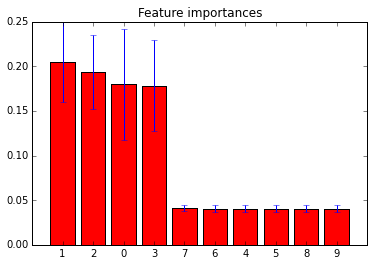

In [40]:
# Build a classification task using 3 informative features
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=10000, n_features=10, n_informative=4, n_redundant=0, n_repeated=0, n_classes=2, random_state=0, shuffle=False)
rankFeatures (X,y, True)


## Fonction de dummysation
Dumuise des colonnes d'un df en générant autant de colonnes que de valeurs par colonnes et en enlevant la colonne origine. Nom des nouvelles colonnes = nom de la colonne + '_' + valeur dummysée   
Prend en argument
* le df à dummyser
* un array avec les noms de colonnes à dummyser

In [8]:
def dummify(X, cols):
    for col in cols:
        dums = pd.get_dummies(X[col], prefix=col)
        X = X.join(dums)
        del X[col]
    return X

# Caterpillar
## Read train data set

In [9]:
train = pd.read_csv('data/train_set.csv')

In [10]:
train.head()

,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,cost
0,TA-00002,S-0066,2013-07-07,0,0,Yes,1,21.905933
1,TA-00002,S-0066,2013-07-07,0,0,Yes,2,12.341214
2,TA-00002,S-0066,2013-07-07,0,0,Yes,5,6.601826
3,TA-00002,S-0066,2013-07-07,0,0,Yes,10,4.687770
4,TA-00002,S-0066,2013-07-07,0,0,Yes,25,3.541561


In [11]:
train.describe()

,annual_usage,min_order_quantity,quantity,cost
count,30213.000000,30213.000000,30213.000000,30213.000000
mean,120.369377,2.084699,38.389369,13.433317
std,1590.331872,12.742776,70.761392,28.663200
min,0.000000,0.000000,1.000000,0.503553
25%,0.000000,0.000000,2.000000,3.878190
50%,0.000000,0.000000,10.000000,6.521146
75%,2.000000,0.000000,40.000000,13.431781
max,150000.000000,535.000000,2500.000000,1000.000000


##Modèle 0 : quick & Dirty avec un seul fichier sans jointures

### Fonction de découpage du fichier train avec sélection des seules features numériques  

In [12]:
def parse_0(X):
    target = X['cost']
    X = X[['annual_usage', 'min_order_quantity','quantity']]
    return X, target

### Entrainement de l'agorithme de régression linéaire

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split

score is 1.21961424554


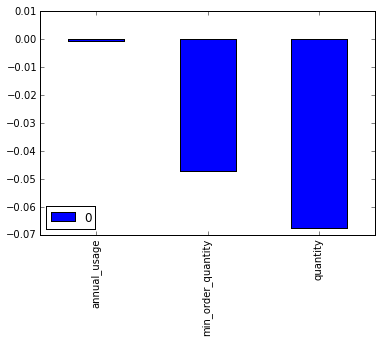

In [14]:
X,y = parse_0(train[train.annual_usage<100000]) # enlève 2 valeurs atypiques. Shape du résultat = (30211, 3)
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0)
lr = LinearRegression()
lr.fit(X_train,y_train)
print('score is '+str(rmsle(lr.predict(X_test),y_test)))
pd.DataFrame(lr.coef_, index=X.columns).plot(kind="bar")

In [15]:
X,y = parse_0(train[train.annual_usage<100000]) # enlève 2 valeurs atypiques. Shape du résultat = (30211, 3)
lr = LinearRegression()
evaluate_model(lr,X,y, False)

Evaluator is: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
Mean score on 20 iterations is: 1.02679598847
                            0
-0.065234            quantity
-0.045982  min_order_quantity
-0.000570        annual_usage


### Générer le submission_set

In [16]:
test = pd.read_csv('data/test_set.csv')
X = test[['annual_usage', 'min_order_quantity','quantity']]
preds = pd.DataFrame(lr.predict(X),columns=['cost'])
submitForCaterpillar(test,preds)

setting 2312 negative cost values to zero
generated submit/submit_2015-08-22-11-17.csv


In [17]:
#test.shape

In [18]:
#test.head()

In [19]:
#preds.head()

In [20]:
#test.count()

In [21]:
#print(X.shape,test.shape,preds.shape)

## Modèle 1. Avec dummysation de bracket pricing

In [22]:
def parse_1(X):
    target = pd.DataFrame([])
    if 'cost' in X.columns:
        # si on passe le jeu de test réel, cost n'est pas là
        target = X['cost']
    X = X[['annual_usage', 'min_order_quantity','quantity','bracket_pricing']]
    X = dummify(X,['bracket_pricing'])
    return X, target

In [23]:
X,y = parse_1(train.copy())

In [24]:
X.head()

,annual_usage,min_order_quantity,quantity,bracket_pricing_No,bracket_pricing_Yes
0,0,0,1,0,1
1,0,0,2,0,1
2,0,0,5,0,1
3,0,0,10,0,1
4,0,0,25,0,1


### Application d'une régression linéaire simple

Evaluator is: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
Mean score on 20 iterations is: 0.953880900538


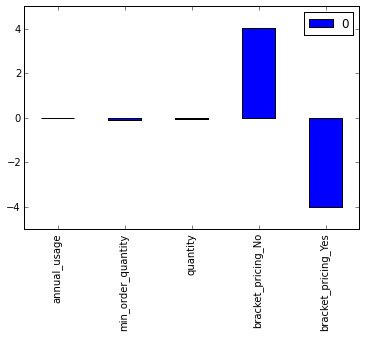

In [25]:
X,y = parse_1(train.copy())
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
evaluate_model(lr,X,y)

### Génération fichier de soumission

In [26]:
test = pd.read_csv('data/test_set.csv')
X, y = parse_1(test)
lr.predict(X)
preds = pd.DataFrame(lr.predict(X),columns=['cost'])
submitForCaterpillar(test,preds)

setting 109 negative cost values to zero
generated submit/submit_2015-08-22-11-17.csv


## Autre essai à refactorer

In [27]:
train_base = pd.read_csv('data/train_set.csv')
train_br =  train_base[train_base.bracket_pricing=="Yes"]
train_br = train_br[train_br.annual_usage<100000]
train_br.bracket_pricing.value_counts()

Yes    26282
dtype: int64

In [28]:
train_nbr = train_base[train_base.bracket_pricing=="No"]
train_nbr = train_nbr[train_nbr.annual_usage<100000]
train_nbr.bracket_pricing.value_counts()

No    3929
dtype: int64

In [29]:
X,y = parse_1(train_br)

In [30]:
X = X[['annual_usage', 'quantity']]

Evaluator is: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
Mean score on 20 iterations is: 0.910097688146


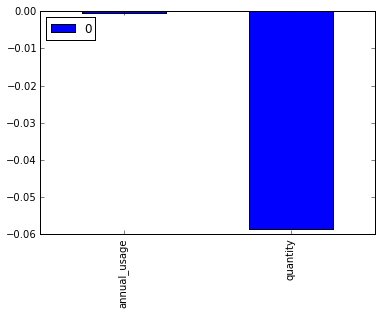

In [31]:
evaluate_model(lr,X,y)

Evaluator is: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
Mean score on 20 iterations is: 1.19614489628


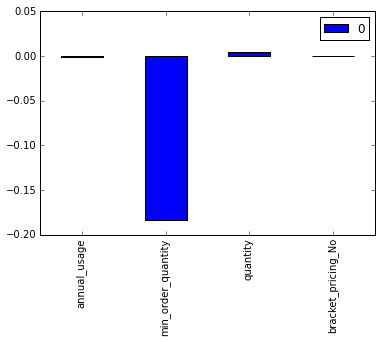

In [32]:
X,y = parse_1(train_nbr)
evaluate_model(lr,X,y)

In [33]:
#pd.merge(train,tube, on='tube_assembly_id')

## Modèle trivial : Calcul du score du modèle qui prédit toujours la moyenne des costs
permet d'avoir une référence de la valeur des scores 

In [34]:
rmsle(train.cost, np.ones(train.shape[0])*train.cost.mean())

0.94748992900412188

conclusion : les deux premiers modèles sont tellement simplistes qu'ils ne font pas mieux que ce modèle bête. 
Must do better !!

## Modèle 3: Appliquer un random Forrest

In [35]:
import sklearn.ensemble as en
rf = en.RandomForestRegressor(n_estimators=40, max_depth=25)
X,y = parse_1(train.copy())
evaluate_model(rf,X,y)

Evaluator is: RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
Mean score on 20 iterations is: 0.577861908541


### Générer le fichier de submission

In [37]:
test = pd.read_csv('data/test_set.csv')
X, y = parse_1(test)
rf.predict(X)
preds = pd.DataFrame(rf.predict(X),columns=['cost'])
submitForCaterpillar(test,preds)

generated submit/submit_2015-08-22-11-17.csv


## modèle 4 :  jointure sur les variables dummysées de tube, tube_assembly pour enrichir la matrice X 

In [38]:
train = pd.read_csv('data/train_set.csv')
train.head()

,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,cost
0,TA-00002,S-0066,2013-07-07,0,0,Yes,1,21.905933
1,TA-00002,S-0066,2013-07-07,0,0,Yes,2,12.341214
2,TA-00002,S-0066,2013-07-07,0,0,Yes,5,6.601826
3,TA-00002,S-0066,2013-07-07,0,0,Yes,10,4.687770
4,TA-00002,S-0066,2013-07-07,0,0,Yes,25,3.541561


In [76]:
def parse_4(X):
    if 'cost' in X.columns:
        target = X['cost']
    else :
        # si on passe le jeu de test réel, cost n'est pas là
         target = pd.DataFrame([])
    # Dummify test or train
    X = X[['tube_assembly_id','annual_usage','supplier','min_order_quantity','bracket_pricing','quantity']]
    X = dummify(X,['bracket_pricing', 'supplier'])
    print X.shape
    
    # Dummify and Merge tube
    tube = pd.read_csv('data/tube.csv')
    del tube['material_id']
    tube = dummify(tube,['end_a_1x','end_a_2x','end_x_1x','end_x_2x','end_a','end_x'])
    X = pd.merge(X,tube, on='tube_assembly_id')
    print(X.shape)

    # Dummify and Merge specs
    specs = pd.read_csv('data/specs.csv')
    specs = dummify(specs,['spec1','spec2','spec3','spec4','spec5','spec6','spec7','spec8','spec9','spec10'])
    X = pd.merge(X,specs, on='tube_assembly_id')
    print(X.shape)

    # Dummify and Merge Bill of materials
    # billOfMaterials = pd.read_csv('data/bill_of_materials.csv')
    # billOfMaterials = dummify(billOfMaterials, ['component_id_1','component_id_2','component_id_3','component_id_4','component_id_5','component_id_6','component_id_7','component_id_8' ])
    #X = pd.merge(X,billOfMaterials, on='tube_assembly_id')
    #print X.shape
    
    del X['tube_assembly_id']
    return X, target

In [40]:
train = pd.read_csv('data/train_set.csv')
train = parse_4(train.copy())

(30213, 63)
(30213, 132)
(30213, 397)


In [41]:
train.head()

AttributeError: 'tuple' object has no attribute 'head'

In [42]:
tube = pd.read_csv('data/tube.csv')
tube.head()
#tube.dtypes

,tube_assembly_id,material_id,diameter,wall,length,num_bends,bend_radius,end_a_1x,end_a_2x,end_x_1x,end_x_2x,end_a,end_x,num_boss,num_bracket,other
0,TA-00001,SP-0035,12.70,1.65,164,5,38.10,N,N,N,N,EF-003,EF-003,0,0,0
1,TA-00002,SP-0019,6.35,0.71,137,8,19.05,N,N,N,N,EF-008,EF-008,0,0,0
2,TA-00003,SP-0019,6.35,0.71,127,7,19.05,N,N,N,N,EF-008,EF-008,0,0,0
3,TA-00004,SP-0019,6.35,0.71,137,9,19.05,N,N,N,N,EF-008,EF-008,0,0,0
4,TA-00005,SP-0029,19.05,1.24,109,4,50.80,N,N,N,N,EF-003,EF-003,0,0,0


In [43]:
tube = pd.read_csv('data/tube.csv')
tube = dummify(tube,['end_a_1x','end_a_2x','end_x_1x','end_x_2x','end_a','end_x'])
tube.head()

,tube_assembly_id,material_id,diameter,wall,length,num_bends,bend_radius,num_boss,num_bracket,other,...,end_x_EF-017,end_x_EF-018,end_x_EF-019,end_x_EF-021,end_x_EF-022,end_x_EF-023,end_x_EF-024,end_x_EF-025,end_x_EF-026,end_x_NONE
0,TA-00001,SP-0035,12.70,1.65,164,5,38.10,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,TA-00002,SP-0019,6.35,0.71,137,8,19.05,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,TA-00003,SP-0019,6.35,0.71,127,7,19.05,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,TA-00004,SP-0019,6.35,0.71,137,9,19.05,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,TA-00005,SP-0029,19.05,1.24,109,4,50.80,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [72]:
tube.dtypes

tube_assembly_id     object
material_id          object
diameter            float64
wall                float64
length              float64
num_bends             int64
bend_radius         float64
num_boss              int64
num_bracket           int64
other                 int64
end_a_1x_N          float64
end_a_1x_Y          float64
end_a_2x_N          float64
end_a_2x_Y          float64
end_x_1x_N          float64
end_x_1x_Y          float64
end_x_2x_N          float64
end_x_2x_Y          float64
end_a_EF-001        float64
end_a_EF-002        float64
end_a_EF-003        float64
end_a_EF-004        float64
end_a_EF-005        float64
end_a_EF-006        float64
end_a_EF-007        float64
end_a_EF-008        float64
end_a_EF-009        float64
end_a_EF-010        float64
end_a_EF-011        float64
end_a_EF-012        float64
                     ...   
end_a_EF-023        float64
end_a_EF-025        float64
end_a_NONE          float64
end_x_9999          float64
end_x_EF-001        

In [44]:
specs = pd.read_csv('data/specs.csv')
specs.head()
specs.dtypes

tube_assembly_id    object
spec1               object
spec2               object
spec3               object
spec4               object
spec5               object
spec6               object
spec7               object
spec8               object
spec9               object
spec10              object
dtype: object

In [45]:
specs = pd.read_csv('data/specs.csv')
specs = dummify(specs,['spec1','spec2','spec3','spec4','spec5','spec6','spec7','spec8','spec9','spec10'])
#specs['spec1_SP-0029']
specs.head()

,tube_assembly_id,spec1_SP-0001,spec1_SP-0002,spec1_SP-0003,spec1_SP-0004,spec1_SP-0005,spec1_SP-0006,spec1_SP-0007,spec1_SP-0009,spec1_SP-0010,...,spec7_SP-0088,spec7_SP-0092,spec8_SP-0062,spec8_SP-0080,spec8_SP-0082,spec8_SP-0088,spec9_SP-0070,spec9_SP-0082,spec9_SP-0088,spec10_SP-0080
0,TA-00001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,TA-00002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,TA-00003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,TA-00004,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,TA-00005,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
billOfMaterials = pd.read_csv('data/bill_of_materials.csv')
billOfMaterials.head()

,tube_assembly_id,component_id_1,quantity_1,component_id_2,quantity_2,component_id_3,quantity_3,component_id_4,quantity_4,component_id_5,quantity_5,component_id_6,quantity_6,component_id_7,quantity_7,component_id_8,quantity_8
0,TA-00001,C-1622,2,C-1629,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TA-00002,C-1312,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TA-00003,C-1312,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TA-00004,C-1312,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TA-00005,C-1624,1,C-1631,1,C-1641,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
billOfMaterials = pd.read_csv('data/bill_of_materials.csv')
billOfMaterials = dummify(billOfMaterials, ['component_id_1','component_id_2','component_id_3','component_id_4','component_id_5','component_id_6','component_id_7','component_id_8' ])
billOfMaterials.head()

,tube_assembly_id,quantity_1,quantity_2,quantity_3,quantity_4,quantity_5,quantity_6,quantity_7,quantity_8,component_id_1_9999,...,component_id_6_C-1560,component_id_6_C-1639,component_id_6_C-1920,component_id_6_C-2005,component_id_6_C-2021,component_id_7_C-0355,component_id_7_C-0968,component_id_7_C-1019,component_id_7_C-1921,component_id_8_C-1981
0,TA-00001,2,2,NaN,NaN,NaN,NaN,NaN,NaN,0,...,0,0,0,0,0,0,0,0,0,0
1,TA-00002,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,...,0,0,0,0,0,0,0,0,0,0
2,TA-00003,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,...,0,0,0,0,0,0,0,0,0,0
3,TA-00004,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,...,0,0,0,0,0,0,0,0,0,0
4,TA-00005,1,1,1,NaN,NaN,NaN,NaN,NaN,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
#comp_adaptator = pd.read_csv('data/comp_adaptor.csv')
#comp_adaptator.head()

In [77]:
train = pd.read_csv('data/train_set.csv')
print(train.shape)
train = pd.merge(train,tube, on='tube_assembly_id')
print(train.shape)
train = pd.merge(train,specs, on='tube_assembly_id')
print(train.shape)
#train = pd.merge(train,billOfMaterials, on='tube_assembly_id')
#print(train.shape)

(30213, 8)
(30213, 77)
(30213, 342)


In [57]:
train.head()

,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,cost,material_id,diameter,...,spec7_SP-0088,spec7_SP-0092,spec8_SP-0062,spec8_SP-0080,spec8_SP-0082,spec8_SP-0088,spec9_SP-0070,spec9_SP-0082,spec9_SP-0088,spec10_SP-0080
0,TA-00002,S-0066,2013-07-07,0,0,Yes,1,21.905933,SP-0019,6.35,...,0,0,0,0,0,0,0,0,0,0
1,TA-00002,S-0066,2013-07-07,0,0,Yes,2,12.341214,SP-0019,6.35,...,0,0,0,0,0,0,0,0,0,0
2,TA-00002,S-0066,2013-07-07,0,0,Yes,5,6.601826,SP-0019,6.35,...,0,0,0,0,0,0,0,0,0,0
3,TA-00002,S-0066,2013-07-07,0,0,Yes,10,4.687770,SP-0019,6.35,...,0,0,0,0,0,0,0,0,0,0
4,TA-00002,S-0066,2013-07-07,0,0,Yes,25,3.541561,SP-0019,6.35,...,0,0,0,0,0,0,0,0,0,0


## Appliquer une LR sur cette nouvelle matrice

In [79]:
train = pd.read_csv('data/train_set.csv')
lr = LinearRegression(n_jobs=-1)
rf = en.RandomForestRegressor(n_estimators=20, max_depth=10)
X,y = parse_4(train.copy())
X.head()
evaluate_model(rf,X,y,False)
#evaluate_model(lr,X,y,False)

(30213, 63)
(30213, 131)
(30213, 396)
Evaluator is: RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
Mean score on 20 iterations is: 0.386857993335


In [80]:
test = pd.read_csv('data/test_set.csv')
X, y = parse_4(test)
rf.predict(X)
preds = pd.DataFrame(rf.predict(X),columns=['cost'])
submitForCaterpillar(test,preds)

(30235, 62)
(30235, 130)
(30235, 395)


ValueError: Number of features of the model must  match the input. Model n_features is 395 and  input n_features is 394 

### comparer avec une régression linéaire de base

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
0.850484957799


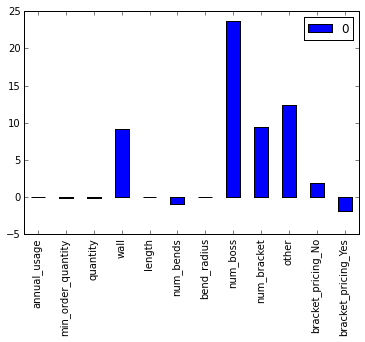

In [328]:
X,y = parse_2(train.copy())
lr = LinearRegression()
evaluate_model(lr,X,y)

## soumission du RF avec matrice joinée sur tube

In [355]:
def parse_3(X):
    print X.columns

    X = X[['annual_usage', 'min_order_quantity','quantity','bracket_pricing','wall','length', 'num_bends','bend_radius','num_boss','num_bracket','other']]
    
    to_dum = ['bracket_pricing']
    for col in to_dum:
        dums = pd.get_dummies(X[col], prefix=col)
        X = X.join(dums)
    del X['bracket_pricing']
    return X

In [356]:
test_submit = pd.read_csv('data/test_set.csv')
test_submit.head()

,id,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity
0,1,TA-00001,S-0066,2013-06-23,0,0,Yes,1
1,2,TA-00001,S-0066,2013-06-23,0,0,Yes,2
2,3,TA-00001,S-0066,2013-06-23,0,0,Yes,5
3,4,TA-00001,S-0066,2013-06-23,0,0,Yes,10
4,5,TA-00001,S-0066,2013-06-23,0,0,Yes,25


In [357]:
test_submit = pd.merge(test_submit,tube, on='tube_assembly_id')
test_submit.head()


,id,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,material_id,diameter,...,bend_radius,end_a_1x,end_a_2x,end_x_1x,end_x_2x,end_a,end_x,num_boss,num_bracket,other
0,1,TA-00001,S-0066,2013-06-23,0,0,Yes,1,SP-0035,12.7,...,38.1,N,N,N,N,EF-003,EF-003,0,0,0
1,2,TA-00001,S-0066,2013-06-23,0,0,Yes,2,SP-0035,12.7,...,38.1,N,N,N,N,EF-003,EF-003,0,0,0
2,3,TA-00001,S-0066,2013-06-23,0,0,Yes,5,SP-0035,12.7,...,38.1,N,N,N,N,EF-003,EF-003,0,0,0
3,4,TA-00001,S-0066,2013-06-23,0,0,Yes,10,SP-0035,12.7,...,38.1,N,N,N,N,EF-003,EF-003,0,0,0
4,5,TA-00001,S-0066,2013-06-23,0,0,Yes,25,SP-0035,12.7,...,38.1,N,N,N,N,EF-003,EF-003,0,0,0


In [358]:
#test_submit = test_submit.drop(['id'],axis=1)
# Codage de la matrice X
X_submit = parse_3(test_submit.copy())
#X_submit2 = X_submit.drop(['id'],axis=1)
# Initialisation et évaluation de la RF
rf = en.RandomForestRegressor(n_estimators=40, max_depth=25)
#X,y = parse_2(train.copy())
rf.fit(X,y)
#evaluate_model(rf,X_submit,y)
# Prediction du y sur X
y_submit = rf.predict(X_submit)
# génréation du fichier de submit
submit(test_submit,y_submit)

Index([u'id', u'tube_assembly_id', u'supplier', u'quote_date', u'annual_usage',
       u'min_order_quantity', u'bracket_pricing', u'quantity', u'material_id',
       u'diameter', u'wall', u'length', u'num_bends', u'bend_radius',
       u'end_a_1x', u'end_a_2x', u'end_x_1x', u'end_x_2x', u'end_a', u'end_x',
       u'num_boss', u'num_bracket', u'other'],
      dtype='object')
generated submit/submit_2015-07-17-16-26.csv


array([ 26.05002409,  15.56851484,   8.42750421, ...,   3.66086399,
        18.09940332,  36.72943919])

In [316]:
rf.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [317]:
X.head()

,annual_usage,min_order_quantity,quantity,wall,length,num_bends,bend_radius,num_boss,num_bracket,other,bracket_pricing_No,bracket_pricing_Yes
0,0,0,1,0.71,137,8,19.05,0,0,0,0,1
1,0,0,2,0.71,137,8,19.05,0,0,0,0,1
2,0,0,5,0.71,137,8,19.05,0,0,0,0,1
3,0,0,10,0.71,137,8,19.05,0,0,0,0,1
4,0,0,25,0.71,137,8,19.05,0,0,0,0,1
